# Jost function method II: resonance state

---
This code is made available as part of the **FRIB-TA Summer School: A Practical Walk Through Formal Scattering Theory: Connecting Bound States, Resonances, and Scattering States in Exotic Nuclei and Beyond**, held virtually
August 4-6, 2021.

https://fribtascattering.github.io/

*Organizers/Lecturers:*
- Kévin Fossez (MSU/ANL)
- Sebastian König (NCSU)
- Heiko Hergert (MSU)

*Author:* Kévin Fossez

*Last update:* Aug 25, 2021

---

In the previous session, you wrote a naive version of the Jost function method and obtained an almost correct bound state wave function. Today, you will solve the issue related to the divergence of the wave function at large distances and improve the stability of the method at short distances.

## Basic setup

In [1]:
# Download and install library helpers
!gdown --id 1sZT60tdWLtmBCFKzs870UhiMurVdSPRk
!unzip -o lib.zip

# Set up pretty 
from IPython.display import set_matplotlib_formats
%matplotlib inline
set_matplotlib_formats('svg')

zsh:1: command not found: gdown
unzip:  cannot find or open lib.zip, lib.zip.zip or lib.zip.ZIP.


/var/folders/ld/0k7b046s3t7dpld1w1b2n_zw0000gn/T/ipykernel_21821/4058438398.py:8: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg')


# Reminder

In [2]:
def pot_WS(r):

    d = 0.618
    R0 = 2.162
    Vo = 41.77
    Vso = 6.991

    exp_r_minus_R0_over_d = np.exp ((r - R0)/d)
    f = -1.0/(1.0 + exp_r_minus_R0_over_d)
    Vnuclear = Vo * f;

    df = exp_r_minus_R0_over_d*f*f/d
    two_l_scalar_s = j*(j+1) - l*(l+1) - 0.75

    Vspin_orbit = 0.0
    if ((two_l_scalar_s != 0) and (Vso != 0.0) and r != 0.0):
        Vspin_orbit = -2.0*two_l_scalar_s*Vso*df/r

    return Vnuclear + Vspin_orbit;

In [3]:
import scipy.special as sp
def Hp_Hm (sign, l, z):
    jl = sp.spherical_jn(l,z)
    yl = sp.spherical_yn(l,z)
    return z*(yl+sign*1.0j*jl)

# Fixing the bound state asymptotic

So far, we wrote and implemented the wave function as follows:

\begin{equation}
u_l(r,k) = \frac{i}{2} \left( F_{l,\eta}^+(k,r) H_{l,\eta}^-(k,r) - F_{l,\eta}^-(k,r) H_{l,\eta}^+(k,r) \right)
\end{equation}

However, we noticed a divergence of the bound state wave function at large distances.

**- Plot the incoming and outgoing Hankel functions and make a guess as to what happened numerically**

**- What is the asymptotic of a bound state radial wave function and how could you impose it numerically?**


In [4]:
def wf_u (k, r, Fp, Fm, l):
    if (r == 0.0): 
        return 0.0

    #is_it_bound = #...
    #if (is_it_bound and #...

    #...

    is_it_bound = (abs(k.real) < 1.0e-8 and k.imag > 0.0)
    if (is_it_bound and abs(Fm) < 1.0e-6):
        Fm = 0.0
    return 1.0j*0.5*(Fp*Hp_Hm(-1.0,l, k*r) - Fm*Hp_Hm(+1.0,l, k*r))

**- apply the same fix for the derivatives of the Jost functions**

\begin{equation}
\frac{\partial}{\partial r}F_{l,\eta}^\pm(k,r) = \pm\frac{1}{ik} \frac{2m}{\hbar^2} V(r)(\mp i) H_{l,\eta}^\pm(k,r) u_{l}(r,k)
\end{equation}

In [5]:
def dF(F, r, k, two_amu_over_hbar2):
    Fp = F[0]
    Fm = F[1]

    #is_it_bound = #...
    is_it_bound = (abs(k.real) < 1.0e-8 and k.imag > 0.0)
    r_cut = 10.0
    if (is_it_bound and abs(Fm) < 1.0e-6):
        Fm = 0.0

    u = wf_u(k,r,Fp,Fm, l)

    dFp = 0.0
    dFm = 0.0

    if r==0.0:
        return [0.0,0.0]

    #...

    Hp = Hp_Hm (+1.0,l, k*r)
    Hm = Hp_Hm (-1.0,l, k*r)
    dFp = +(1.0/(1.0j*k))*two_amu_over_hbar2*pot_WS(r)*(-1.0j*Hp)*u
    dFm = -(1.0/(1.0j*k))*two_amu_over_hbar2*pot_WS(r)*(+1.0j*Hm)*u

    return [dFp,dFm]

**- Run the numerical integration again and see if the asymptotic is correct**

In [6]:
!pip3 install odeintw

from odeintw import odeintw

DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621


In [7]:
def integrate_wf (r_range, k, l, two_amu_over_hbar2):

    u_range=np.array([])
    pot_range = np.array([])

    # initial values of the r-dependent Jost function at r=0
    # they must be declared as complex (even if real) for the ODE solver
    #
    Fp0 = 1.0+0.0j
    Fm0 = 1.0+0.0j
    F0 = np.array([Fp0, Fm0])

    F = odeintw(dF,F0,r_range, args=(k, two_amu_over_hbar2,))

    # extract the outgoing and incoming r-dependent Jost functions
    Fp_range = np.array([F[i][0] for i in range(Nr)])
    Fm_range = np.array([F[i][1] for i in range(Nr)])


    # compute the wave function using the Jost functions obtained
    for i in range(Nr):
        Fp = Fp_range[i]
        Fm = Fm_range[i]
        r = r_range[i]
        u = wf_u(k,r,Fp,Fm, l)
        u_range = np.append(u_range, u)

        pot_range = np.append(pot_range, pot_WS(r))

    return u_range, pot_range, Fp_range, Fm_range


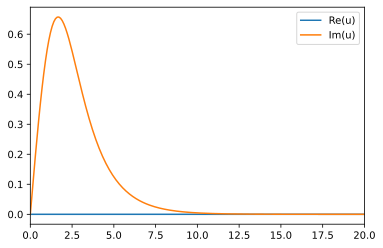

In [8]:
import numpy as np

two_amu_over_hbar2 = 0.038540695 # MeV^-1 fm^-2
l=0
j=0.5
k=0.6569928182*1.0j # fm^-1, bound state for the potential considered

# radial discretization (in fm)
ri = 0.0
rf = 20.0
Nr = 200
r_range = np.linspace(ri,rf,Nr)
r_step = (ri-rf)/Nr

u_range, pot_range, Fp_range, Fm_range = integrate_wf (r_range, k, l, two_amu_over_hbar2)


import matplotlib.pyplot as plt
plt.xlim(0.0,20.0)
plt.plot(r_range, (np.array(u_range)).real,'-', label='Re(u)')
plt.plot(r_range, (np.array(u_range)).imag,'-', label='Im(u)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

**- Plot the real and imaginary parts of Fp and Fm to check that only Fp is non-zero**

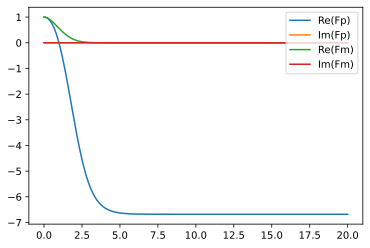

In [9]:
plt.plot(r_range, (np.array(Fp_range)).real,'-', label='Re(Fp)')
plt.plot(r_range, (np.array(Fp_range)).imag,'-', label='Im(Fp)')
plt.plot(r_range, (np.array(Fm_range)).real,'-', label='Re(Fm)')
plt.plot(r_range, (np.array(Fm_range)).imag,'-', label='Im(Fm)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

# Resonance wave function

Now, we consider a resonance for the same WS potential but with $l=1$ and $j=3/2$, and with the momentum `k=0.1756993618-0.03680609808j` (you could find this using Sebastian's code).

As you have seen in the lecture, a resonance has the same outgoing asymptotic than bound states except that it does not decreases exponentially.

**- Run the code again with these parameters and enjoy**

**- Once you are satisfied, check your result against the benchmark solution provided below**

In [10]:
!gdown --id 1LEa-M-FLZfyl4yXqf9qcX213he__Teya

zsh:1: command not found: gdown


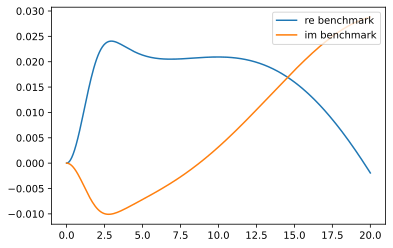

In [11]:
def get_data_u(file_name):
    arr_r=[]
    arr_u_re=[]
    arr_u_im=[]
    for line in open (file_name):
        if line[0] != "#":
            values = line.strip ("\n").split ()

            arr_r.append (float(values[0]))
            arr_u_re.append (float (values[1]))
            arr_u_im.append (float (values[2]))

    return arr_r, arr_u_re, arr_u_im


mksize=1.2
arr_r_bench, arr_u_re_bench, arr_u_im_bench = get_data_u("benchmark_wf_res")
plt.plot(arr_r_bench, arr_u_re_bench, linestyle="-", marker="", markersize=mksize, label="re benchmark")
plt.plot(arr_r_bench, arr_u_im_bench, linestyle="-", marker="", markersize=mksize, label="im benchmark")

plt.legend(loc='upper right', fontsize=10)
plt.show()

You can see the relatively localized part of the wave function in the inner region below about 6 fm, and then the development of the outgoing asymptotic with an oscillating behavior whose amplitude increases exponentially.

**- Can you understand intuitively what such an asymptotic means physically? (even though it is not acceptable in Hibert space quantum mechanics)**

We have not put any particular condition on Fp and Fm for the resonance wave function, but we know that Fm should be zero.

**- Plot the real and imaginary parts of Fp and Fm again to check**

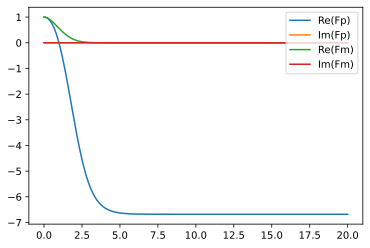

In [12]:
plt.plot(r_range, (np.array(Fp_range)).real,'-', label='Re(Fp)')
plt.plot(r_range, (np.array(Fp_range)).imag,'-', label='Im(Fp)')
plt.plot(r_range, (np.array(Fm_range)).real,'-', label='Re(Fm)')
plt.plot(r_range, (np.array(Fm_range)).imag,'-', label='Im(Fm)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

# Scattering wave function

Now, fix the momentum to a real positive value to look at a scattering state, like $k=1.0$ fm.

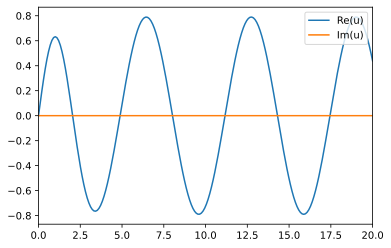

In [13]:
import numpy as np

two_amu_over_hbar2 = 0.038540695 # MeV^-1 fm^-2
l=0
j=0.5
k=1.0

# radial discretization (in fm)
ri = 0.0
rf = 20.0
Nr = 200
r_range = np.linspace(ri,rf,Nr)
r_step = (ri-rf)/Nr

u_range, pot_range, Fp_range, Fm_range = integrate_wf (r_range, k, l, two_amu_over_hbar2)


import matplotlib.pyplot as plt
plt.xlim(0.0,20.0)
plt.plot(r_range, (np.array(u_range)).real,'-', label='Re(u)')
plt.plot(r_range, (np.array(u_range)).imag,'-', label='Im(u)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

Here, both Fp and Fm should be non-zero.

**- Plot the real and imaginary parts of Fp and Fm again to check**

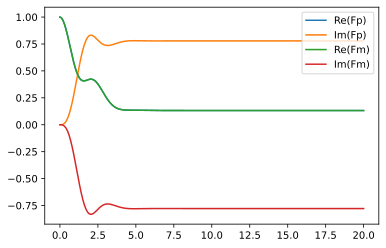

In [14]:
plt.plot(r_range, (np.array(Fp_range)).real,'-', label='Re(Fp)')
plt.plot(r_range, (np.array(Fp_range)).imag,'-', label='Im(Fp)')
plt.plot(r_range, (np.array(Fm_range)).real,'-', label='Re(Fm)')
plt.plot(r_range, (np.array(Fm_range)).imag,'-', label='Im(Fm)')

plt.legend(loc='upper right', fontsize=10)
plt.show()

# Improvement at short distances

In the examples above, we did not have any problem at short distances. However, we could have had some issues near the origin because of the irregular component $y_l(z)$ of the Hp and Hm functions.

\begin{equation}
H_{l}^\pm(z) = z [ y_l(z) \pm i j_l(z) ]
\end{equation}

One way to avoid any potential issue numerically is to replace Hp and Hm in the wave function and the derivatives of the Jost functions, and to rearrange the terms as to have in their expression:

\begin{equation}
y_l(z) [ F_{l,\eta}^+(k,r) - F_{l,\eta}^-(k,r) ]
\end{equation}

That way, when $r \approx 0$ and the Jost functions are almost equal, the large value of the irregular spherical Bessel function is reduced by the small difference in the braket.

# For your curiosity

**- Try putting a value of the momentum normally associated with an antibound state and look at the wave function. Can you find one where Fm is almost zero at large distances? (almost a pole)**

A capturing resonance is the time-reversed of a decaying resonance. I gave you the following pole for an $l=1$ and $j=3/2$ decaying resonance: `k=0.1756993618-0.03680609808j`.

**- Can you find the value of k for the capturing resonance? Plot its wave function. How does it looks like?**
